<a href="https://colab.research.google.com/github/WojciechTyczynski/Autoencoders-for-image-quality-improvement-with-OMHU/blob/main/noise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import os

# Support funtions

In [2]:
def imshow(img):
    #img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

In [3]:
def showOrigDec(orig, noise, num=10):
    import matplotlib.pyplot as plt
    n = num
    plt.figure(figsize=(20, 4))

    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i+1)
        imshow(orig[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        # display noisy
        ax = plt.subplot(2, n, i +1 + n)
        imshow(noise[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.figtext(0.5,0.95, "ORIGINAL IMAGES", ha="center", va="top", fontsize=14, color="r")
    plt.figtext(0.5,0.5, "NOISY IMAGES", ha="center", va="top", fontsize=14, color="r")
    plt.subplots_adjust(hspace = 0.3 )
        
    plt.show()

In [4]:
def showOrigNoiseOut(orig, noise, denoise, num=10):
    import matplotlib.pyplot as plt
    n = num
    plt.figure(figsize=(20, 6))
    denoise = denoise.detach().numpy()

    for i in range(n):
        # display original
        ax = plt.subplot(3, n, i+1)
        imshow(orig[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display noisy image
        ax = plt.subplot(3, n, i +1 + n)
        imshow(noise[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        # display denoised image
        ax = plt.subplot(3, n, i +1 + n + n)
        imshow(denoise[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
    plt.figtext(0.5,0.95, "ORIGINAL IMAGES", ha="center", va="top", fontsize=14, color="r")
    plt.figtext(0.5,0.65, "NOISY IMAGES", ha="center", va="top", fontsize=14, color="r")
    plt.figtext(0.5,0.35, " DENOISED RECONSTRUCTED IMAGES", ha="center", va="top", fontsize=14, color="r")
    plt.subplots_adjust(hspace = 0.5 )
    plt.show()

# Dataset

In [5]:
transform = transforms.Compose(
        [transforms.ToTensor(), ])

# Load dataset
batch_size = 20

trainset = torchvision.datasets.CIFAR10(root='/content/drive/MyDrive/deep_learning', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='/content/drive/MyDrive/deep_learning', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

used_categories = range(len(classes))

train_data_iter = iter(trainloader)
test_data_iter = iter(testloader)
print('used classes:', classes)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting /content/drive/MyDrive/deep_learning/cifar-10-python.tar.gz to /content/drive/MyDrive/deep_learning
Files already downloaded and verified
used classes: ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


In [6]:
def add_noise_and_clip_data(data):
  noise = np.random.normal(loc=0.0, scale=0.1, size=len(data))
  data = data + noise
  data = np.clip(data, 0., 1.)
  return data

In [7]:
noisy_trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
noisy_testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
noise_factor = 0.5
for data in noisy_trainloader:
  images, _ = data
  noisy_imgs = images + noise_factor * torch.randn(*images.shape)
  noisy_imgs = np.clip(noisy_imgs, 0., 1.)
  data = noisy_imgs, _



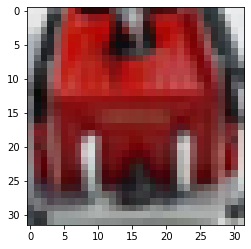

In [8]:
dataiter = iter(noisy_trainloader)
images, labels = dataiter.next()
imshow(images[1])

In [9]:
print("# Training data")
print("Number of points:", len(trainset))
x, y = next(iter(trainloader))
print("Batch dimension [B x C x H x W]:", x.shape)
print("Number of distinct labels:", len(set(trainset.targets)))


print("\n# Test data")
print("Number of points:", len(testset))
x, y = next(iter(testloader))
print("Batch dimension [B x C x H x W]:", x.shape)
print("Number of distinct labels:", len(set(testset.targets)))

# Training data
Number of points: 50000
Batch dimension [B x C x H x W]: torch.Size([20, 3, 32, 32])
Number of distinct labels: 10

# Test data
Number of points: 10000
Batch dimension [B x C x H x W]: torch.Size([20, 3, 32, 32])
Number of distinct labels: 10


# Network


In [10]:
class ConvAutoencoder(nn.Module):
  def __init__(self):
      super(ConvAutoencoder, self).__init__()

      #Encoder
      self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
      self.conv2 = nn.Conv2d(64, 16, 3, padding=1)
      # self.conv3 = nn.Conv2d(32, 16, 3, padding=1)
      # self.conv4 = nn.Conv2d(16, 8, 3, padding=1)
      self.pool = nn.MaxPool2d(2, 2)

      #Decoder
      # self.t_conv1 = nn.ConvTranspose2d(8, 16, 2, stride=2)
      # self.t_conv2 = nn.ConvTranspose2d(16, 32, 2, stride=2)
      self.t_conv1 = nn.ConvTranspose2d(16, 64, 2, stride=2)
      self.t_conv2 = nn.ConvTranspose2d(64, 3, 2, stride=2)

     

  def forward(self, x):
      x = F.relu(self.conv1(x))
      x = self.pool(x)
      x = F.relu(self.conv2(x))
      x = self.pool(x)
      # x = F.relu(self.conv3(x))
      # x = self.pool(x)
      # x = F.relu(self.conv4(x))
      # x = self.pool(x)
      x = F.relu(self.t_conv1(x))
      # x = F.relu(self.t_conv2(x))
      # x = F.relu(self.t_conv3(x))
      x = F.sigmoid(self.t_conv2(x))

      return x
  
#Instantiate the model
model = ConvAutoencoder()
print(model)

ConvAutoencoder(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(16, 64, kernel_size=(2, 2), stride=(2, 2))
  (t_conv2): ConvTranspose2d(64, 3, kernel_size=(2, 2), stride=(2, 2))
)


In [11]:
#Loss function
# criterion = nn.BCELoss()
criterion = nn.MSELoss()

#Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [12]:
def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device

device = get_device()
print(device)
model.to(device)

cuda:0


ConvAutoencoder(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(16, 64, kernel_size=(2, 2), stride=(2, 2))
  (t_conv2): ConvTranspose2d(64, 3, kernel_size=(2, 2), stride=(2, 2))
)

# Noise

In [13]:
noise_factor=0.2
# obtain one batch of training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
# convert images to numpy for display

noisy_imgs = images + noise_factor * torch.randn(*images.shape)
noisy_imgs = np.clip(noisy_imgs, 0., 1.)
images = images.numpy() 
noisy_imgs=noisy_imgs.numpy()

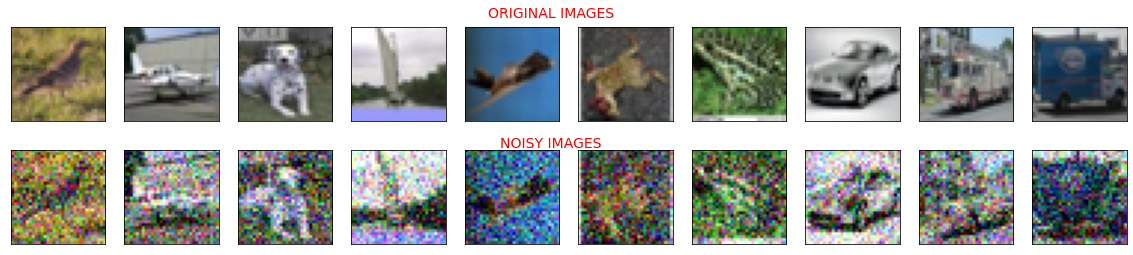

In [14]:
showOrigDec(images,noisy_imgs)

In [17]:
def save_image(image, epoch):
  plt.imshow(np.transpose(image.cpu(), (1, 2, 0)))
  plt.savefig('/content/drive/MyDrive/deep_learning/{}.png'.format(epoch))


In [ ]:
#Epochs
n_epochs = 50
epoch_train_loss = []
epoch_test_loss = []

for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0
    test_loss = 0.0

    #Training
    for data in trainloader:
        images, _ = data
        noisy_imgs = images + noise_factor * torch.randn(*images.shape)
        noisy_imgs = np.clip(noisy_imgs, 0., 1.)
        noisy_imgs=noisy_imgs.to(device)
        images = images.to(device)
        optimizer.zero_grad()
        outputs = model(noisy_imgs)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*images.size(0)
  
    epoch_train_loss.append(train_loss/len(trainloader))

    with torch.no_grad():

        for (data,turn) in (zip(testloader, range(len(trainloader)))):

            test_images, _ = next(iter(testloader))
            noisy_test_images = test_images + noise_factor * torch.randn(*test_images.shape)
            noisy_test_images = np.clip(noisy_test_images, 0., 1.)
            # save the output of the model
            
            if turn==0:
              # save the image before model, on purpose always with the same name so we have it to compare
              save_image(test_images[0], 'base')
              save_image(noisy_test_images[0], 'noisy')

            noisy_test_images=noisy_test_images.to(device)
            # perform a forward pass through the model
            output_test = model(noisy_test_images)
            if turn==0:
              # save the image run through the model
              save_image(output_test[0], epoch)



            # gather data for the validation step
            test_loss += (criterion(noisy_test_images, output_test).item()*test_images.size(0))
        
    epoch_test_loss.append(test_loss/len(testloader))

    train_loss = train_loss/len(trainloader)
    test_loss = test_loss/len(testloader)
    print('Epoch: {} \tTraining Loss: {:.6f}.  Test Loss: {:.6f}'.format(epoch, train_loss, test_loss))

import pandas as pd
errors = {'train' : epoch_train_loss, 'test' : epoch_test_loss}
df_errors = pd.DataFrame(data = errors)
df_errors.to_csv('/content/drive/MyDrive/deep_learning/noise_errors.csv')

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 1 	Training Loss: 0.139795.  Test Loss: 0.706351
Epoch: 2 	Training Loss: 0.129027.  Test Loss: 0.700107


Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.7/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.7/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/usr/lib/python3.7/shutil.py", line 498, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.7/shutil.py", line 496, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-rbqcqivr'


Epoch: 3 	Training Loss: 0.123905.  Test Loss: 0.694127
Epoch: 4 	Training Loss: 0.120944.  Test Loss: 0.690347
Epoch: 5 	Training Loss: 0.119006.  Test Loss: 0.689122
Epoch: 6 	Training Loss: 0.117621.  Test Loss: 0.687986
Epoch: 7 	Training Loss: 0.116615.  Test Loss: 0.686054
Epoch: 8 	Training Loss: 0.115771.  Test Loss: 0.684723
Epoch: 9 	Training Loss: 0.115000.  Test Loss: 0.684682
Epoch: 10 	Training Loss: 0.114302.  Test Loss: 0.682339
Epoch: 11 	Training Loss: 0.113705.  Test Loss: 0.683475
Epoch: 12 	Training Loss: 0.113314.  Test Loss: 0.681986
Epoch: 13 	Training Loss: 0.112920.  Test Loss: 0.681275
Epoch: 14 	Training Loss: 0.112559.  Test Loss: 0.681178
Epoch: 15 	Training Loss: 0.112310.  Test Loss: 0.680484
Epoch: 16 	Training Loss: 0.111944.  Test Loss: 0.679496
Epoch: 17 	Training Loss: 0.111735.  Test Loss: 0.681681
Epoch: 18 	Training Loss: 0.111559.  Test Loss: 0.680565
Epoch: 19 	Training Loss: 0.111289.  Test Loss: 0.677930
Epoch: 20 	Training Loss: 0.111107.  T

In [ ]:
# obtain one batch of test images
dataiter = iter(testloader)
images, labels = dataiter.next()

# add noise to the test images
noisy_imgs = images + noise_factor * torch.randn(*images.shape)
noisy_imgs = np.clip(noisy_imgs, 0., 1.)

# get sample outputs
output = model(noisy_imgs.cuda())



# output is resized into a batch of iages
output = output.view(batch_size, 3, 32, 32)
# use detach when it's an output that requires_grad
output = output.detach().cpu()

In [ ]:
showOrigNoiseOut(images.cpu(), noisy_imgs.cpu(), output.cpu())

# Gaussian noise

In [ ]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [ ]:
# obtain one batch of training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
# convert images to numpy for display

noisy_imgs = AddGaussianNoise(0., 0.1).__call__(images)
images = images.numpy() 
noisy_imgs=noisy_imgs.numpy()

In [ ]:
showOrigDec(images,noisy_imgs)

In [ ]:
#Epochs
n_epochs = 50

for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0
    test_loss = 0.0

    #Training
    for data in trainloader:
        images, _ = data
        noisy_imgs = images + AddGaussianNoise(0., 0.1).__call__(images)
        noisy_imgs=noisy_imgs.to(device)
        images = images.to(device)
        optimizer.zero_grad()
        outputs = model(noisy_imgs)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*images.size(0)
  

    with torch.no_grad():
        
        # Just load a single batch from the test loader
        test_images, _ = next(iter(testloader))
        test_images = test_images.to(device)
        
        # perform a forward pass through the model
        test_outputs = model(test_images)
        
        # gather data for the validation step
        test_loss = criterion(test_outputs, test_images).item()*test_images.size(0)
        
        
    train_loss = train_loss/len(trainloader)
    test_loss = test_loss/len(test_images)
    print('Epoch: {} \tTraining Loss: {:.6f}.  Test Loss: {:.6f}'.format(epoch, train_loss, test_loss))

if not os.path.exists('./weights'):
    os.mkdir('./weights')
torch.save(model.state_dict(), "./weights/autoencoder.pkl")

In [ ]:
# obtain one batch of test images
dataiter = iter(testloader)
images, labels = dataiter.next()

# add noise to the test images
noisy_imgs = AddGaussianNoise(0., 0.1).__call__(images)

# get sample outputs
output = model(noisy_imgs.cuda())

# output is resized into a batch of iages
output = output.view(batch_size, 3, 32, 32)
# use detach when it's an output that requires_grad
output = output.detach().cpu()

In [ ]:
showOrigNoiseOut(images.cpu(), noisy_imgs.cpu(), output.cpu())